In [3]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import pandas as pd
import scipy.stats

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

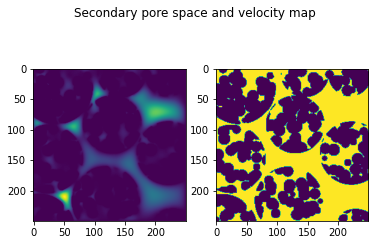

In [4]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')

In [5]:
secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype('int')
secondaryImageOut[secondaryImage == 1] = 255

# Save vtk files
ps.io.to_vtk(velDataNormSecondary, 'secondaryVelocityImage')
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

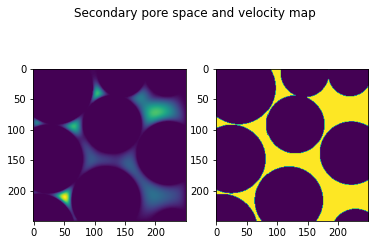

In [6]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png')

# Extract pore network information

In [8]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]

secondaryRegions = snowFiltSecondary.regions


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1484
Peaks after trimming saddle points:  957
Peaks after trimming nearby peaks:  937
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 937/937 [00:10<00:00, 90.88it/s] 


In [9]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]

primaryRegions = snowFiltPrimary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 16.87it/s]


In [10]:
ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')
ps.io.to_vtk(primaryRegions,'snowRegionsPrimary')

In [11]:
snowIM = snowFiltSecondary.im
print('The initial image has', np.sum(secondaryImage),'number of pore elements')

snowRegionIM = secondaryRegions[secondaryRegions > 0]
print('The identified pore regions account for',len(snowRegionIM),'number of elements')

diff = np.abs(len(snowRegionIM) - np.sum(secondaryImage))
print('The difference between these two is', diff)
print('This difference must be due to some SNOW algorithm imperfections')

The initial image has 8437192 number of pore elements
The identified pore regions account for 8435161 number of elements
The difference between these two is 2031
This difference must be due to some SNOW algorithm imperfections


# Plot distribution of pore diameter

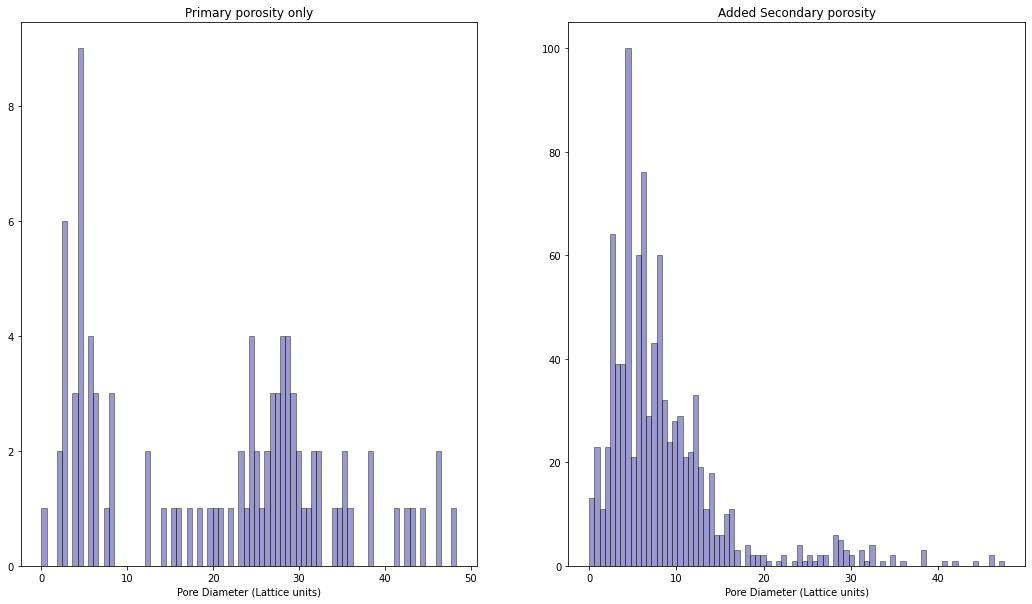

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryPoreDiamVec, ax=axes[0], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Diameter (Lattice units)')

sns.distplot(secondaryPoreDiamVec, ax=axes[1], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Diameter (Lattice units)')

fig.savefig('poreDiamHist.png')

### I will say pore diameter > 20 units are "big pores"

# Skeleton implementation

Find skeleton for secondary image and collect info

In [13]:
# Skeleton for secondary image
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = secondaryPoreDiamVec[regionLabel - 1]
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam


Main loop: 100%|██████████| 938/938 [00:16<00:00, 57.33it/s]


In [14]:
# Skeleton for primary image
cubeSize = len(primaryImage)
visit = np.zeros(len(np.unique(primaryRegions)))
primaryPoreDiamImage = np.zeros(primaryImage.shape)
allPrimaryRegions = np.unique(primaryRegions)
tempImage = np.zeros(primaryRegions.shape)
primaryPoreDiamVectorSkeleton = np.zeros(len(allPrimaryRegions))

primarySkelImage = ski.morphology.skeletonize(primaryImage)

for a in tqdm.tqdm(range(0,len(allPrimaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = primaryPoreDiamVec[regionLabel - 1]
                    primaryPoreDiamImage[primaryRegions == regionLabel] = poreDiam



Main loop: 100%|██████████| 94/94 [00:01<00:00, 56.61it/s]


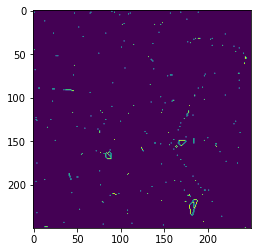

In [15]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')
plt.imshow(secondarySkelImage[:,:,40])
plt.savefig('secondarySkeletonSlice.png')

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')

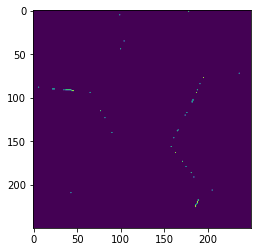

In [16]:
#################################################################
ps.io.to_vtk(primarySkelImage,'primarySkeletonWholeImage')
plt.imshow(primarySkelImage[:,:,40])
plt.savefig('primarySkeletonSlice.png')

primaryImageOut = np.copy(primaryImage)
primaryImageOut = primaryImageOut.astype(int)
primaryImageOut[primaryImage == 1] = 255
ps.io.to_vtk(primaryImageOut,'primaryImage')

# Now plot velocitites on skeleton and extract information

In [17]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Secondary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Secondary porosity loop: 100%|██████████| 250/250 [00:42<00:00,  5.92it/s]


In [18]:
primaryVelocitiesSkeleton = []
primaryPoreDiamSkeleton = []
primaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Primary porosity loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if primarySkelImage[a,b,c] != 0:
                primaryVelocitiesSkeleton = np.append(primaryVelocitiesSkeleton,velDataNormPrimary[a,b,c])
                primaryPoreDiamSkeleton = np.append(primaryPoreDiamSkeleton, primaryPoreDiamImage[a,b,c])
                primaryPoreRegionSkeleton = np.append(primaryPoreRegionSkeleton, primaryRegions[a,b,c])

Primary porosity loop: 100%|██████████| 250/250 [00:35<00:00,  7.05it/s]


# Plot pore velocities with pore diameters

Try taking computing a representative velocity threshold

In [24]:
secondary_metric_PoreVelocity =  []
secondaryMeanPoreVelocity =  []
secondarySkeletonPoreDiam = []
secondarySkeletonPoreRegion = []

for a in tqdm.tqdm(range(0, len(allSecondaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == currentRegion]
        secondaryMeanPoreVelocity = np.append(secondaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        secondary_metric_PoreVelocity = np.append(secondary_metric_PoreVelocity, np.median(skeletonPoreVel))

        # Adjust indices between regionProps and snow algorithm
        secondarySkeletonPoreDiam = np.append(secondarySkeletonPoreDiam, poreInfoSecondary['pore.diameter'][currentRegion-1] )

        secondarySkeletonPoreRegion = np.append(secondarySkeletonPoreRegion, currentRegion)

Main Loop: 100%|██████████| 938/938 [00:00<00:00, 6791.49it/s]


In [27]:
primary_metric_PoreVelocity =  []
primaryMeanPoreVelocity =  []
primarySkeletonPoreDiam = []
primarySkeletonPoreRegion = []

for a in tqdm.tqdm(range(0, len(allPrimaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = primaryVelocitiesSkeleton[primaryPoreRegionSkeleton == currentRegion]
        primaryMeanPoreVelocity = np.append(primaryMeanPoreVelocity, np.mean(skeletonPoreVel))
        primary_metric_PoreVelocity = np.append(primary_metric_PoreVelocity, np.median(skeletonPoreVel))

        # Adjust indices between regionProps and snow algorithm
        primarySkeletonPoreDiam = np.append(primarySkeletonPoreDiam, poreInfoPrimary['pore.diameter'][currentRegion-1] )

        primarySkeletonPoreRegion = np.append(primarySkeletonPoreRegion, currentRegion)

Main Loop: 100%|██████████| 94/94 [00:00<00:00, 9392.40it/s]


# Define low flow and large pore thresholds

In [44]:
lowFlowVelCutoff = 1.42 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20


### Secondary porosity sample

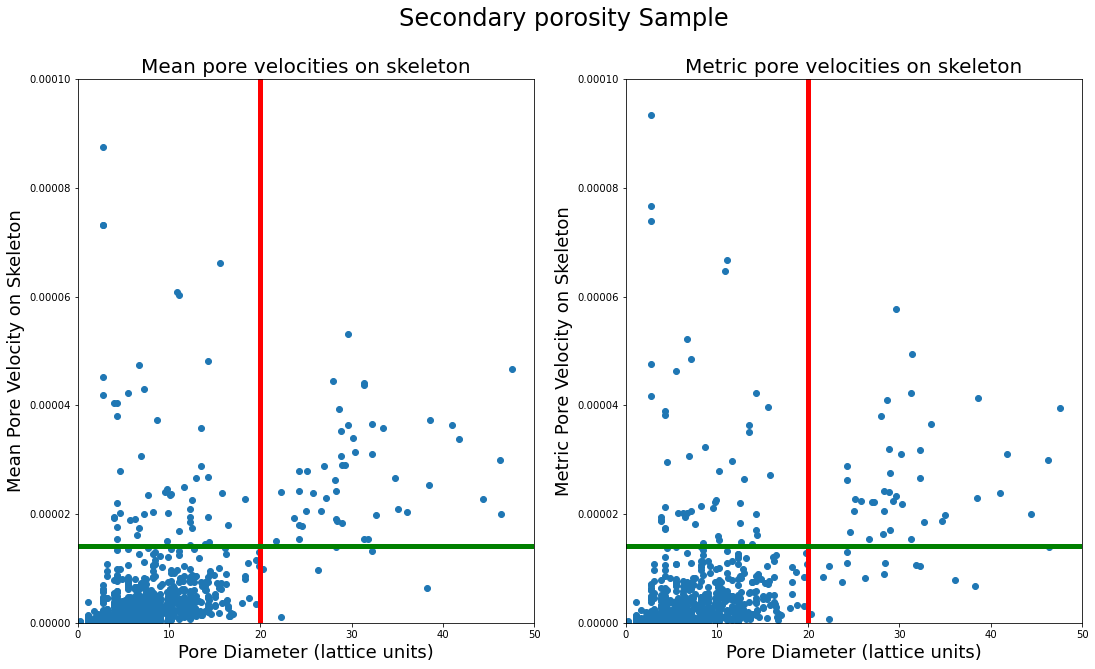

In [45]:
yMax = 0.0001


fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Secondary porosity Sample', fontsize=24)

axes[0].scatter(secondarySkeletonPoreDiam, secondaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,50])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)


axes[1].scatter(secondarySkeletonPoreDiam, secondary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Metric Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('Metric pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,50])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('secondaryPoreVelAveraging.png')


### Primary porosity sample

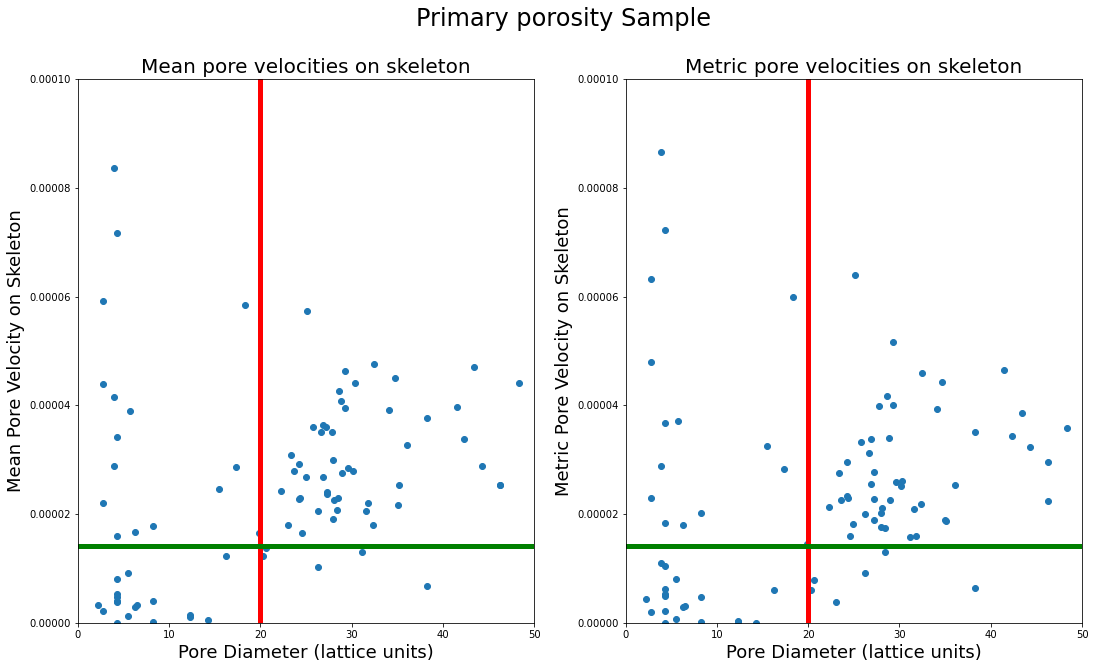

In [46]:

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Primary porosity Sample', fontsize=24)

axes[0].scatter(primarySkeletonPoreDiam, primaryMeanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].set_xlim([0,50])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(primarySkeletonPoreDiam, primary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Metric Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('Metric pore velocities on skeleton', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].set_xlim([0,50])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('primaryPoreVelAveraging.png')



### Plot pore velocity metric for both samples

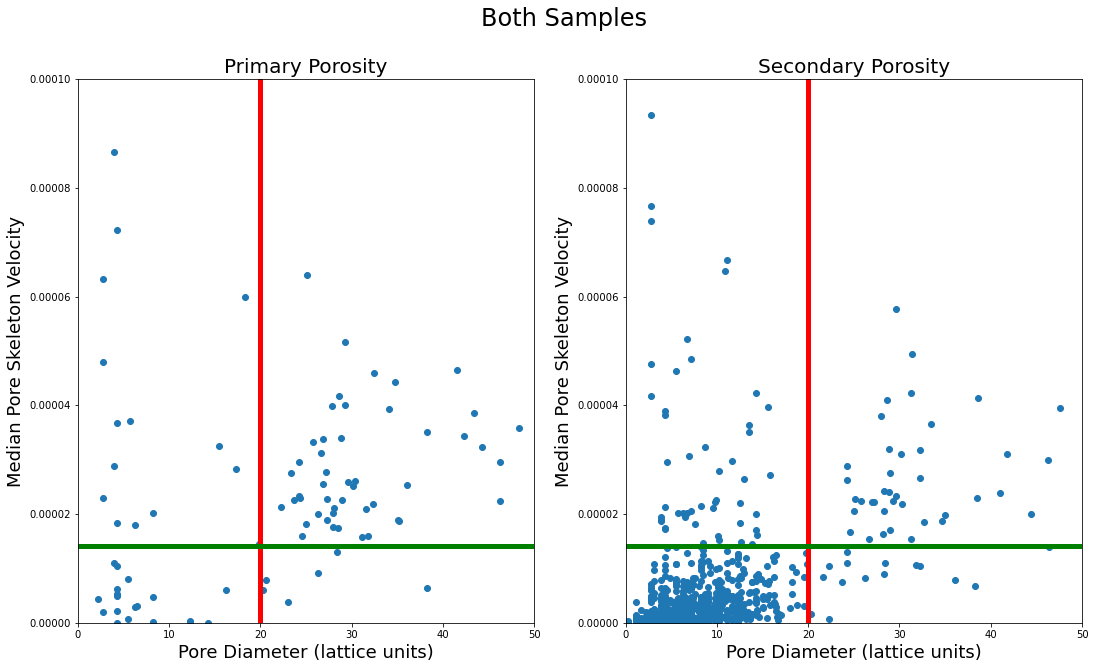

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Both Samples', fontsize=24)

axes[0].scatter(primarySkeletonPoreDiam, primary_metric_PoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[0].set_title('Primary Porosity', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].set_xlim([0,50])
axes[0].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[0].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

axes[1].scatter(secondarySkeletonPoreDiam, secondary_metric_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Skeleton Velocity', fontsize=18)
axes[1].set_title('Secondary Porosity', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].set_xlim([0,50])
axes[1].plot([poreDiamThresh, poreDiamThresh],[0,yMax],'r',lw=5)
axes[1].plot([0,50],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

fig.savefig('bothPorosityMetric.png')


## Try histogram of velocity metric with custom bins and pore diam filt

Small pores
883
just large pores
54


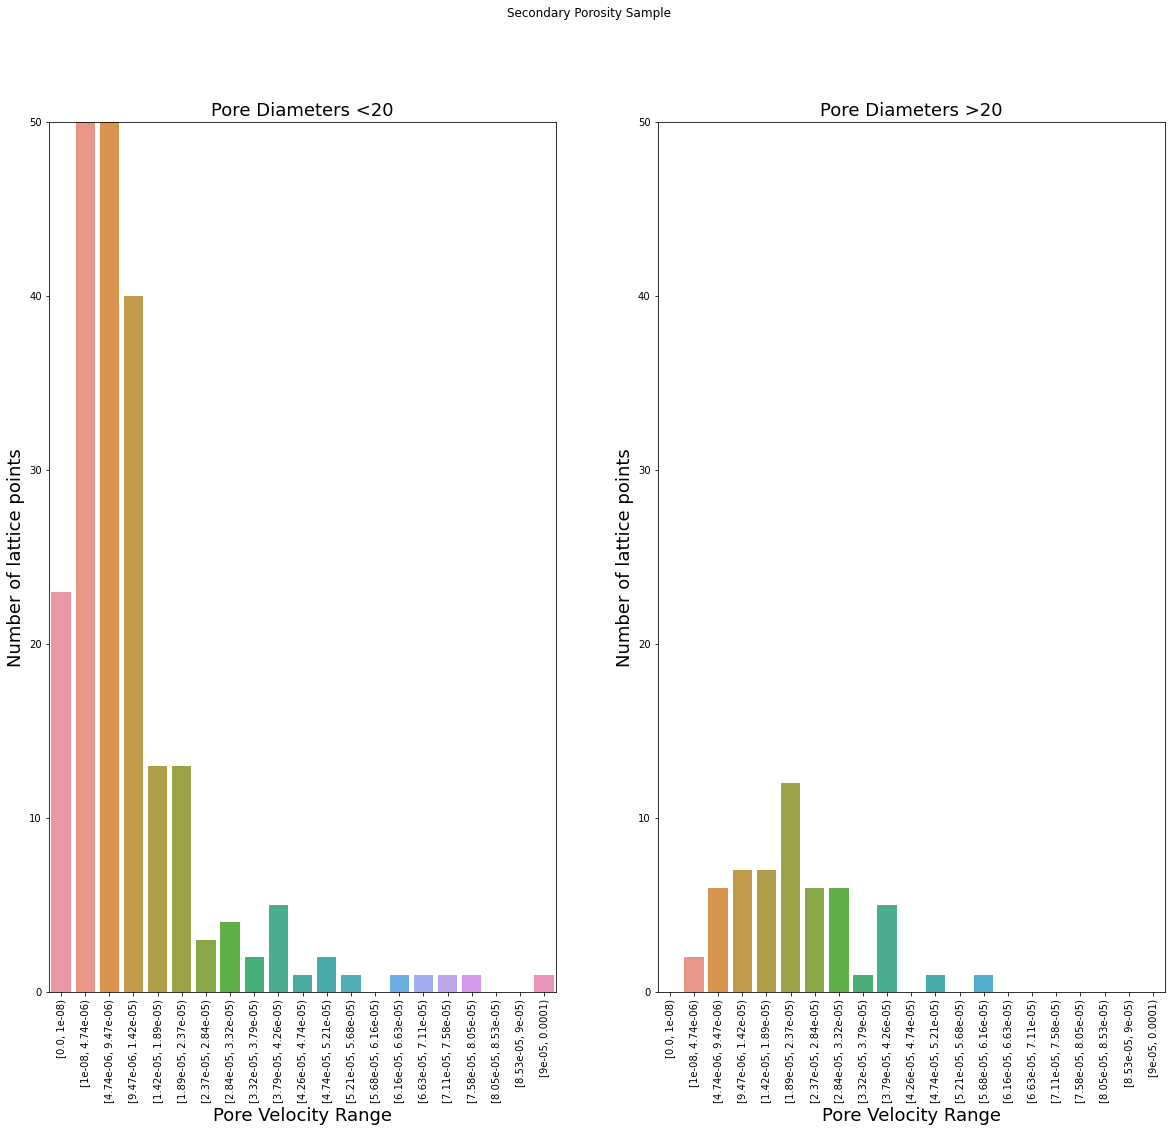

In [48]:
metricFilt = secondary_metric_PoreVelocity[secondarySkeletonPoreDiam < poreDiamThresh]
# number of large pores
smallPores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam < poreDiamThresh]
largePores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam > poreDiamThresh]

print('Small pores')
print(len(smallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})


############################################################
metricFilt = secondary_metric_PoreVelocity[secondarySkeletonPoreDiam > poreDiamThresh]
# number of large pores
numLargePores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam > poreDiamThresh]
print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Secondary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Diameters <'+str(poreDiamThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_title('Pore Diameters >'+str(poreDiamThresh), fontsize=18)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,50])
axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('secondaryCustomHistIQR.png')

Small pores
39
just large pores
54


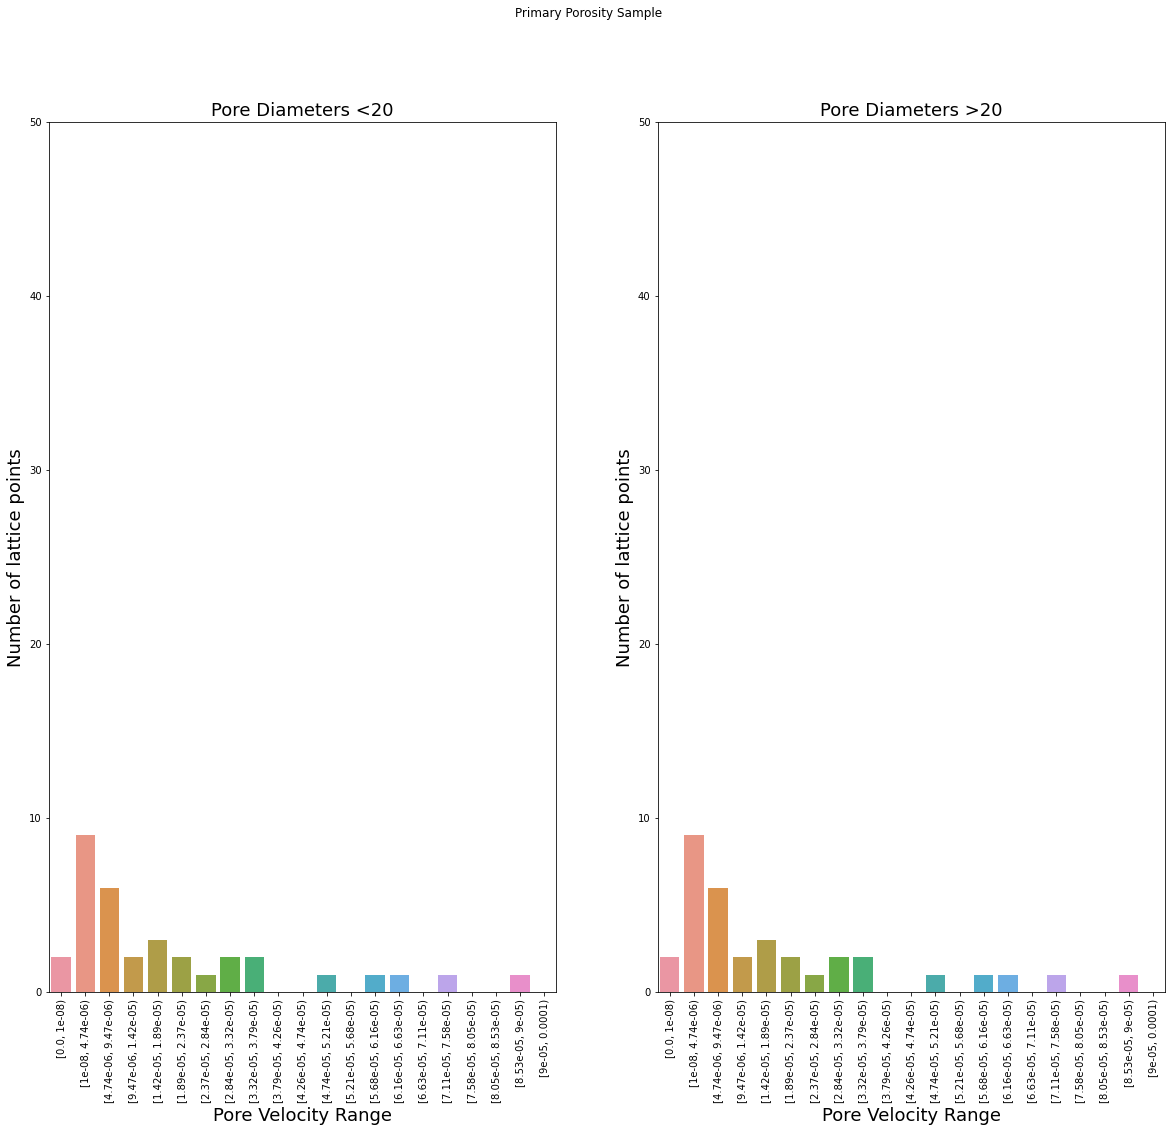

In [49]:
metricFilt = primary_metric_PoreVelocity[primarySkeletonPoreDiam < poreDiamThresh]
# number of large pores
numSmallPores = primarySkeletonPoreDiam[primarySkeletonPoreDiam < poreDiamThresh]
print('Small pores')
print(len(numSmallPores))

bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_small = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})


############################################################
IQRFilt = primary_metric_PoreVelocity[primarySkeletonPoreDiam > poreDiamThresh]
# number of large pores
numLargePores = primarySkeletonPoreDiam[primarySkeletonPoreDiam > poreDiamThresh]
print('just large pores')
print(len(numLargePores))

df_large = pd.DataFrame({'skelVel': metricFilt,
                        'vel_group': pd.cut(metricFilt, bins=bins, right=False)})

############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))
fig.suptitle('Primary Porosity Sample')

sns.countplot(data=df_small,x='vel_group',ax=axes[0] )
sns.countplot(data=df_large,x='vel_group',ax=axes[1])

axes[0].set_title('Pore Diameters <'+str(poreDiamThresh), fontsize=18)
axes[1].set_title('Pore Diameters >'+str(poreDiamThresh), fontsize=18)
axes[0].tick_params(axis='x', labelrotation=90)
axes[1].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

axes[0].set_xlabel('Pore Velocity Range', fontsize=18)
axes[0].set_ylabel('Number of lattice points', fontsize=18)

axes[1].set_xlabel('Pore Velocity Range', fontsize=18)
axes[1].set_ylabel('Number of lattice points', fontsize=18)

fig.savefig('primaryCustomHistIQR.png')

### Plot velocity histogram for all pores, both samples

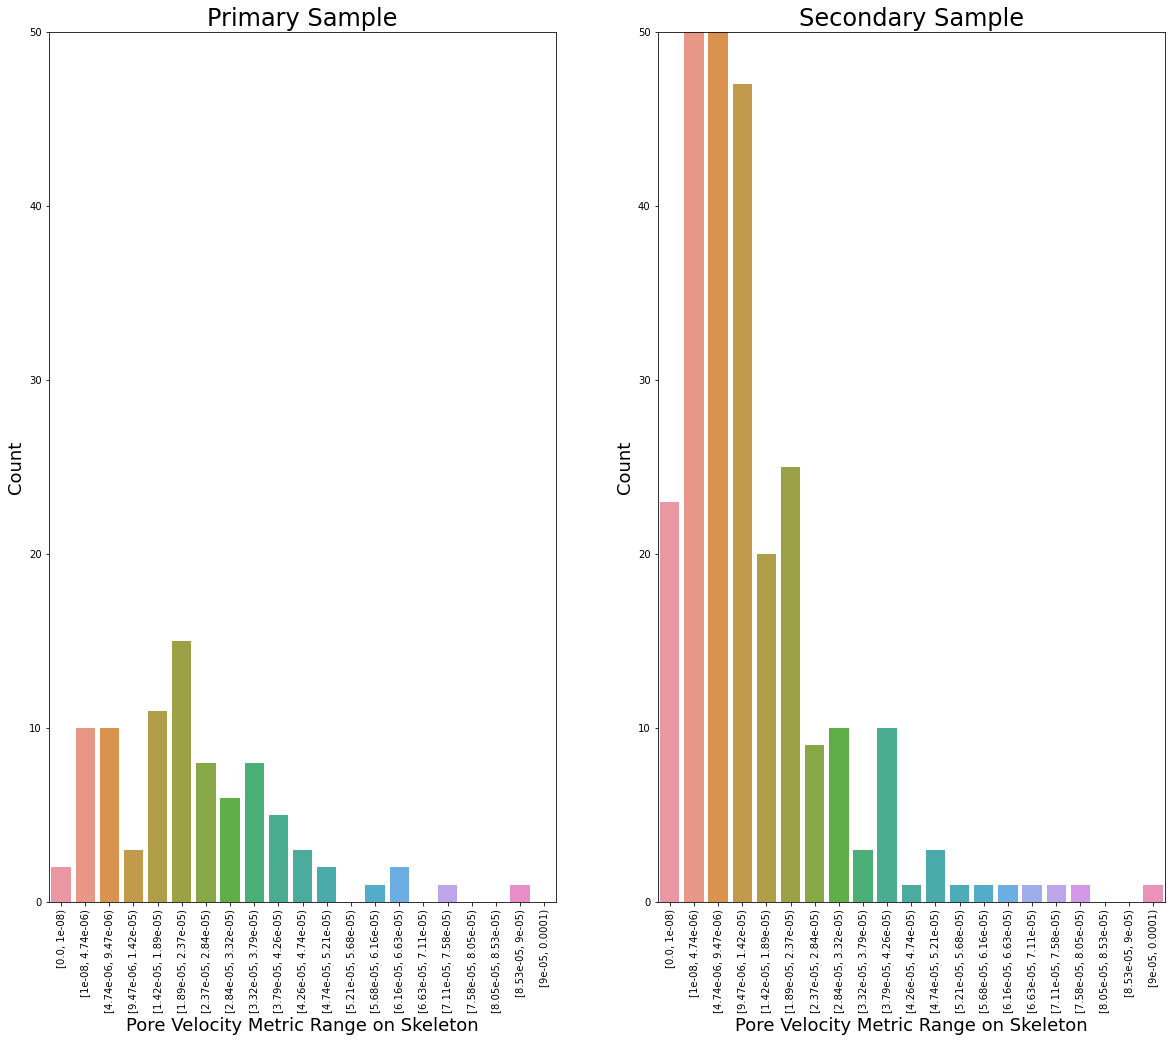

In [50]:
bins = np.linspace(0, 0.00009, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 0.0001)
bins = np.insert(bins, 1, 0.00000001)

df_primary = pd.DataFrame({'skelVelPrimary': primary_metric_PoreVelocity,
                        'vel_groupPrimary': pd.cut(primary_metric_PoreVelocity, bins=bins, right=False)})

df_secondary = pd.DataFrame({'skelVelSecondary': secondary_metric_PoreVelocity,
                        'vel_groupSecondary': pd.cut(secondary_metric_PoreVelocity, bins=bins, right=False)})


############################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 16))

sns.countplot(data=df_primary,x='vel_groupPrimary',ax=axes[0] )
sns.countplot(data=df_secondary,x='vel_groupSecondary',ax=axes[1])

axes[0].set_title('Primary Sample', fontsize=24)
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].set_ylim([0,50])
axes[0].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)

axes[1].set_title('Secondary Sample', fontsize=24)
axes[1].tick_params(axis='x', labelrotation=90)
axes[1].set_ylim([0,50])
axes[1].set_xlabel('Pore Velocity Metric Range on Skeleton', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)

fig.savefig('bothSamplesMetric_Hist.png')




Separate all pores with low velocity

In [51]:
bigSecondaryPores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam > poreDiamThresh]
bigSecondaryPoreRegions = secondarySkeletonPoreRegion[secondarySkeletonPoreDiam > poreDiamThresh]
bigSecondaryPoreVel = secondary_metric_PoreVelocity[secondarySkeletonPoreDiam > poreDiamThresh]
#lowFlowPores = bigSecondaryPores[]

smallSecondaryPores = secondarySkeletonPoreDiam[secondarySkeletonPoreDiam < poreDiamThresh]
smallSecondaryPoreRegions = secondarySkeletonPoreRegion[secondarySkeletonPoreDiam < poreDiamThresh]
smallSecondaryPoreVel = secondary_metric_PoreVelocity[secondarySkeletonPoreDiam < poreDiamThresh]


lowFlowBigPoreRegions = bigSecondaryPoreRegions[bigSecondaryPoreVel <= lowFlowVelCutoff]
lowFlowBigPoreDiam = bigSecondaryPores[bigSecondaryPoreVel <= lowFlowVelCutoff]
lowFlowBigPoreFlow = bigSecondaryPoreVel[bigSecondaryPoreVel <= lowFlowVelCutoff]

highFlowBigPoreDiam = bigSecondaryPores[bigSecondaryPoreVel > lowFlowVelCutoff]

print('There are',str(len(lowFlowBigPoreDiam)),'low flow pores of large pore diameter')
print('There are',str(len(highFlowBigPoreDiam)),'high flow pores of large pore diameter')

There are 15 low flow pores of large pore diameter
There are 39 high flow pores of large pore diameter


In [52]:
lowFlowBigIMOut = np.zeros(secondaryImage.shape)
lowFlowBigIM = np.zeros(secondaryImage.shape)
lowFlowBigCount = 0

highFlowBigIMOut = np.zeros(secondaryImage.shape)
highFlowBigIM = np.zeros(secondaryImage.shape)
highFlowBigCount = 0

for a in tqdm.tqdm(range(0,len(secondarySkeletonPoreRegion)),'Flow Region Loop'):

    currentRegion = secondarySkeletonPoreRegion[a]

    if currentRegion in lowFlowBigPoreRegions:
        lowFlowBigIMOut[secondaryRegions == currentRegion] = 255
        lowFlowBigIM[secondaryRegions == currentRegion] = 1
        lowFlowBigCount = lowFlowBigCount + 1
    else:
        if secondarySkeletonPoreDiam[a] > poreDiamThresh:
            highFlowBigIMOut[secondaryRegions == currentRegion] = 255
            highFlowBigIM[secondaryRegions == currentRegion] = 1
            highFlowBigCount = highFlowBigCount + 1
            print('High Flow Big Pore', str(currentRegion))


print('Number of big pores with low flow is',str(lowFlowBigCount))
print('Number of big pores with high flow is',str(highFlowBigCount))

Flow Region Loop: 100%|██████████| 937/937 [00:01<00:00, 499.86it/s]


High Flow Big Pore 16.0
High Flow Big Pore 17.0
High Flow Big Pore 48.0
High Flow Big Pore 78.0
High Flow Big Pore 89.0
High Flow Big Pore 106.0
High Flow Big Pore 137.0
High Flow Big Pore 170.0
High Flow Big Pore 182.0
High Flow Big Pore 188.0
High Flow Big Pore 197.0
High Flow Big Pore 280.0
High Flow Big Pore 331.0
High Flow Big Pore 343.0
High Flow Big Pore 344.0
High Flow Big Pore 361.0
High Flow Big Pore 368.0
High Flow Big Pore 385.0
High Flow Big Pore 393.0
High Flow Big Pore 419.0
High Flow Big Pore 430.0
High Flow Big Pore 446.0
High Flow Big Pore 470.0
High Flow Big Pore 505.0
High Flow Big Pore 515.0
High Flow Big Pore 531.0
High Flow Big Pore 547.0
High Flow Big Pore 550.0
High Flow Big Pore 596.0
High Flow Big Pore 619.0
High Flow Big Pore 623.0
High Flow Big Pore 645.0
High Flow Big Pore 660.0
High Flow Big Pore 773.0
High Flow Big Pore 842.0
High Flow Big Pore 889.0
High Flow Big Pore 891.0
High Flow Big Pore 892.0
High Flow Big Pore 901.0
Number of big pores with low f

In [53]:
# Plot big flow regions to compare in paraview
# Write to vtk
ps.io.to_vtk(lowFlowBigIMOut,'lowFlowBigRegions')
ps.io.to_vtk(highFlowBigIMOut,'highFlowBigRegions')

In [54]:
bigPoreIMOut = np.zeros(secondaryImage.shape)
bigPoreIM = np.zeros(secondaryImage.shape)
bigPoreCount = 0

smallPoreIMOut = np.zeros(secondaryImage.shape)
smallPoreIM = np.zeros(secondaryImage.shape)

for a in tqdm.tqdm(range(0,len(secondarySkeletonPoreRegion)),'Pore Region Loop'):

    currentRegion = secondarySkeletonPoreRegion[a]
    currentPoreSize = secondarySkeletonPoreDiam[a]

    if currentPoreSize > poreDiamThresh:
        bigPoreIMOut[secondaryRegions == currentRegion] = 255
        bigPoreIM[secondaryRegions == currentRegion] = 1
        bigPoreCount = bigPoreCount + 1
    else:
        smallPoreIMOut[secondaryRegions == currentRegion] = 125
        smallPoreIM[secondaryRegions == currentRegion] = 1

print('Number of big pores is',str(bigPoreCount))

Pore Region Loop: 100%|██████████| 937/937 [00:29<00:00, 31.41it/s]


Number of big pores is 54


# Compute estimate of porosity domains

Total porosity

In [55]:
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(porosityCalc)

Total porosity:
0.539980288


Estimate of less-mobile porosity

In [59]:
# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1

sumPorosity = np.sum(secondaryImage)/(np.sum(flippedImage)+np.sum(secondaryImage))
print('Summed porosity to check value')
print(sumPorosity)

lessMobileOnes = np.sum(lowFlowBigIM)
total = np.sum(flippedImage) + np.sum(secondaryImage)

lessMobilePorosity = lessMobileOnes/total
print('Less mobile porosity estimate:')
print(lessMobilePorosity)

print('Less mobile fraction of porosity')
lessMobileFrac = (lessMobilePorosity/porosityCalc)
print(lessMobileFrac)

Summed porosity to check value
0.539980288
Less mobile porosity estimate:
0.096903296
Less mobile fraction of porosity
0.17945709899691747


## Estimate how much of "big pores" flow

In [58]:
bigPoreSum = np.sum(bigPoreIM)
smallPoreSum = np.sum(smallPoreIM)

allPoreSum = smallPoreSum + bigPoreSum

fracBigPores = bigPoreSum/(smallPoreSum+bigPoreSum)
print('Fraction of pore space identified as big pores is',str(fracBigPores))

porosityEst = (bigPoreSum + smallPoreSum) / (np.sum(flippedImage)+(bigPoreSum+smallPoreSum))
#print('Sum porosity to check porosity value')
#print(porosityEst)

bigPoresLowFlow = np.sum(lowFlowBigIM)
bigPoresFlow = np.sum(highFlowBigIM)

#print(bigPoresLowFlow+bigPoresFlow)

fracBigPoresFlow = bigPoresFlow / (bigPoresLowFlow + bigPoresFlow)
fracBigPoresLowFlow = bigPoresLowFlow / (bigPoresLowFlow + bigPoresFlow)

print('Fraction of big pore space that flows is',str(fracBigPoresFlow))
print('Fraction of big pore space with low flow is',str(fracBigPoresLowFlow))


Fraction of pore space identified as big pores is 0.6325665864587529
Fraction of big pore space that flows is 0.7162349195556581
Fraction of big pore space with low flow is 0.2837650804443419
